In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LassoCV
from sklearn.model_selection import TimeSeriesSplit
from arch import arch_model
import warnings, os
from tqdm import tqdm
import seaborn as sns
import cvxpy as cp
# from pulp import LpProblem, LpMinimize, LpVariable, LpBinary, lpSum, PULP_CBC_CMD, GUROBI, LpStatus, GUROBI_CMD
import os
import torch 
import random
import sys
import os

In [2]:
# Importing files from folders

sys.path.append(os.path.abspath(os.path.join("..", "scripts")))


### Data preparation
Energy prices, forecasted load and generation and forecasted weather

In [3]:
def preprocess_energy_data(file_path):
    df = pd.read_csv(file_path, index_col=0, parse_dates=True)
    df.index.name = 'Timestamp'
    df.index = pd.to_datetime(df.index, utc=True).tz_convert('Europe/Amsterdam')

    # Handle duplicates
    if df.index.duplicated().sum() > 0:
        df = df.sort_index().groupby(level=0).mean()

    # Force hourly frequency and interpolate missing values
    df = df.asfreq('h').interpolate(limit_direction='both')

    # Target variable
    price_series = df['Price'].dropna()

    # Define variables
    base_vars = [
        'Solar', 'Wind Onshore', 'Wind Offshore',
        'Load Forecast (MW)', 'Actual Aggregated',
        'Biomass', 'Fossil Gas', 'Nuclear', 'Other', 'Waste'
    ]
    weather_vars = [
        'temperature_2m', 'cloudcover', 'wind_speed_10m',
        'shortwave_radiation', 'sunshine_duration', 'windgusts_10m'
    ]
    exog_vars = base_vars + weather_vars
    exog = df[exog_vars].copy()

    # Add time-based features
    df['Hour'] = df.index.hour
    df['IsWeekend'] = (df.index.dayofweek >= 5).astype(float)
    df['Month'] = df.index.month
    month_dummies = pd.get_dummies(df['Month'], prefix='Month', drop_first=True)
    extra_features = pd.concat([df[['Hour', 'IsWeekend']], month_dummies], axis=1).astype(float)

    # Combine and interpolate
    exog_full = pd.concat([exog, extra_features], axis=1).interpolate(limit_direction='both')
    exog_raw = exog_full

    # Scale features
    scaler = StandardScaler()
    exog_scaled = pd.DataFrame(
        scaler.fit_transform(exog_full),
        columns=exog_full.columns,
        index=exog_full.index
    )

   # Scale price
    scaler_price = StandardScaler()
    price_scaled = pd.Series(
        scaler_price.fit_transform(price_series.values.reshape(-1, 1)).flatten(),
        index=price_series.index,
        name="Price"
    )

    # Align indices
    common_index = price_series.index.intersection(exog_scaled.index)
    price_series = price_series.loc[common_index]
    price_scaled = price_scaled.loc[common_index]
    exog_scaled = exog_scaled.loc[common_index]


    return price_series, price_scaled, exog_scaled, exog_raw

file_path = '/Users/larskinkel/Documents/UvA/Master/Thesis/ThesisCoding/data/merged_energy_weather_2022_2024.csv'
price, price_scaled, exog, exog_raw = preprocess_energy_data(file_path)



In [4]:
# Specify selected columns
selected_cols = [
    'Price',
    'Solar',
    'Wind Onshore',
    'Wind Offshore',
    'Load Forecast (MW)',
    'Actual Aggregated',
    'temperature_2m',
    'cloudcover',
    'sunshine_duration'
]
# Combine the price series with the exogenous variables
full_data = pd.concat([price.rename('Price'), exog_raw], axis=1)
full_data = full_data[selected_cols]

# Compute descriptive statistics
desc_stats = full_data.describe().T[['mean', 'std', 'min', '25%', '50%', '75%', 'max']]

# Round for readability
desc_stats_rounded = desc_stats.round(2)

# Display as a clean table
display(desc_stats_rounded)

,mean,std,min,25%,50%,75%,max
Price,138.28,113.14,-500.00,75.88,106.18,174.70,872.96
Solar,58.61,92.30,0.00,0.00,2.00,90.00,428.00
Wind Onshore,866.05,677.97,5.75,281.75,670.50,1358.25,2545.50
Wind Offshore,1320.14,1072.82,0.00,376.00,1071.75,2109.50,4343.00
Load Forecast (MW),11068.13,2244.72,478.75,9955.19,11119.75,12421.75,21256.75
Actual Aggregated,8650.90,2297.95,2571.25,6971.25,8411.75,10098.25,16632.75
temperature_2m,11.56,6.39,-7.40,7.00,11.30,16.20,34.60
cloudcover,68.82,38.91,0.00,31.00,97.00,100.00,100.00
sunshine_duration,1086.36,1597.11,0.00,0.00,0.00,3600.00,3600.00


### Simulate Energy Generation and Demand for specific firm

In [5]:
# Set seed for reproducibility
SEED = 2025
np.random.seed(SEED)

# Generate a continuous hourly index from 2022-01-01 to 2024-12-31 23:00 (no timezone yet)
raw_dates = pd.date_range(start="2022-01-01", end="2024-12-31 23:00", freq="h")

def simulate_pv(dates, peak_kw: float = 50.0) -> np.ndarray:
    hours = dates.hour
    # Day‐of‐day sine‐shape (0 before 6:00, peak at 12:00, 0 after 18:00)
    day_factor = np.clip(np.sin((hours - 6) * np.pi / 12), 0, 1)
    # Seasonal factor: peak around day 172 (≈June 21), floor at 0.2 in mid‐winter
    doy = dates.dayofyear
    seasonal_factor = np.clip(np.cos((doy - 172) * 2 * np.pi / 365), 0.2, 1)
    # Add small noise
    noise = np.random.normal(0, 0.1, size=len(dates))
    pv = peak_kw * day_factor * seasonal_factor * (1 + noise)
    return np.clip(pv, 0.0, None)


def simulate_demand(dates, base_kw: float = 20.0, peak_kw: float = 60.0) -> np.ndarray:
    demand_values = []
    for ts in dates:
        hour = ts.hour
        weekday = ts.weekday()  # 0=Monday, …, 6=Sunday
        if (8 <= hour <= 17) and (weekday < 5):
            # Work hours on weekdays
            val = np.random.normal(loc=peak_kw, scale=5.0)
        else:
            # Off‐hours or weekend
            val = np.random.normal(loc=base_kw, scale=3.0)
        demand_values.append(val)
    return np.clip(demand_values, 0.0, None)


simdata = pd.DataFrame(index=raw_dates)
simdata["generation_kWh"] = simulate_pv(raw_dates)
simdata["demand_kWh"]    = simulate_demand(raw_dates)

raw_dates = pd.date_range(start="2022-01-01", end="2024-12-31 23:00", freq="h")

ambiguous_flags = pd.Series(False, index=raw_dates)
simdata.index = raw_dates.tz_localize(
    "Europe/Amsterdam",
    ambiguous=ambiguous_flags,
    nonexistent='shift_forward'
)

simdata = simdata[~simdata.index.isna()].sort_index()
simdata = simdata.interpolate(method="time", limit_direction="both")

simdata = simdata.join(price.rename("price"), how="left")

simdata["price"] = simdata["price"].ffill().bfill()

missing_price = simdata["price"].isna().sum()
if missing_price:
    print(f"⚠️  Warning: {missing_price} missing price values; interpolating...")
    simdata["price"] = simdata["price"].interpolate(method="time", limit_direction="both")

simdata["buy_price"]  = simdata["price"] / 1000.0       # €/kWh
simdata["sell_price"] = simdata["buy_price"] * 0.30     # 30% of buy‐price

simdata = simdata[~simdata.index.duplicated(keep="first")]

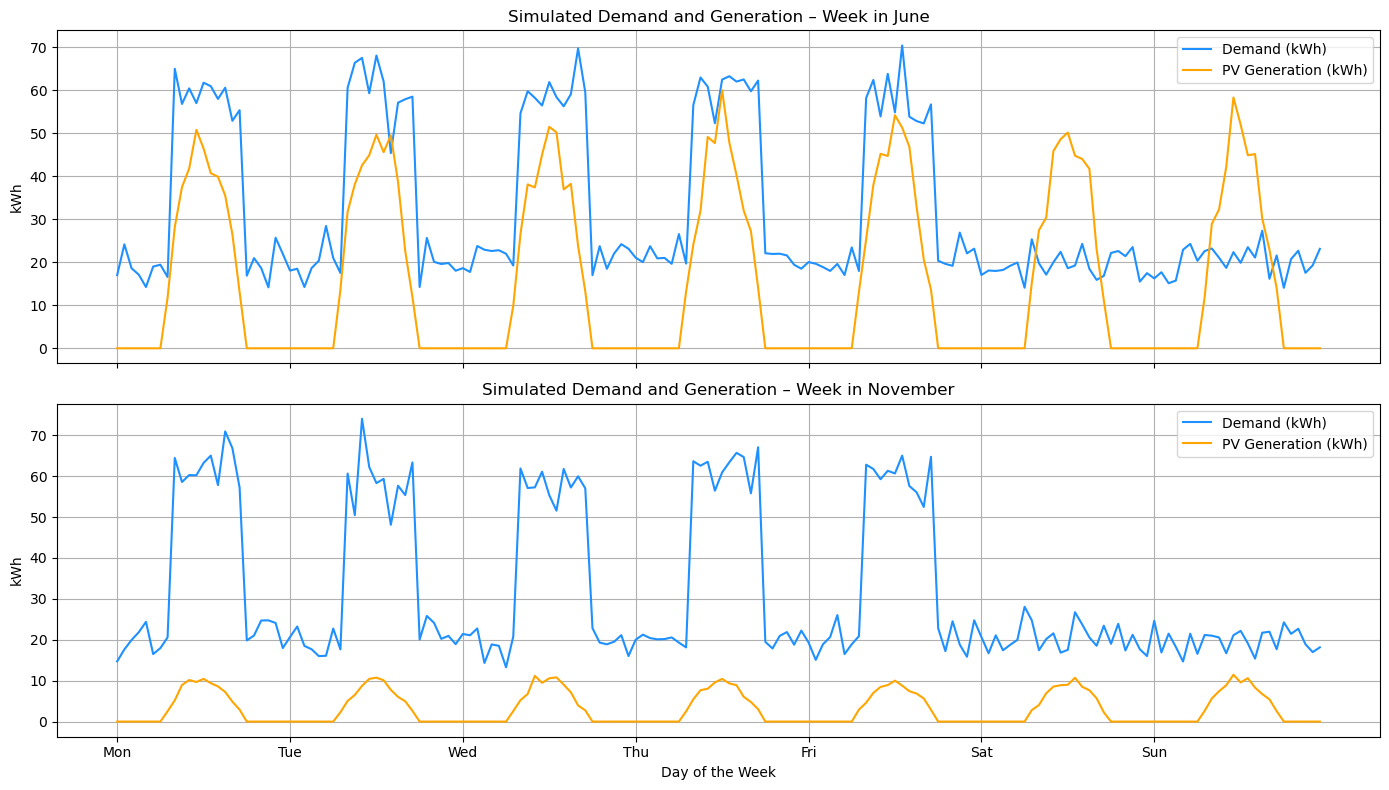

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Select two weeks
june_start = "2022-06-13"
june_end   = "2022-06-19 23:00"
nov_start  = "2022-11-14"
nov_end    = "2022-11-20 23:00"

sim_june = simdata.loc[june_start:june_end]
sim_nov  = simdata.loc[nov_start:nov_end]

# Create x-axis: 0–167 hours, then convert to day labels
x = range(168)
day_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
tick_positions = [i * 24 for i in range(7)]

# Plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# June
ax1.plot(x, sim_june["demand_kWh"].values, label="Demand (kWh)", color="dodgerblue")
ax1.plot(x, sim_june["generation_kWh"].values, label="PV Generation (kWh)", color="orange")
ax1.set_title("Simulated Demand and Generation – Week in June")
ax1.set_ylabel("kWh")
ax1.grid(True)
ax1.legend(loc="upper right")

# November
ax2.plot(x, sim_nov["demand_kWh"].values, label="Demand (kWh)", color="dodgerblue")
ax2.plot(x, sim_nov["generation_kWh"].values, label="PV Generation (kWh)", color="orange")
ax2.set_title("Simulated Demand and Generation – Week in November")
ax2.set_ylabel("kWh")
ax2.set_xlabel("Day of the Week")
ax2.grid(True)
ax2.legend(loc="upper right")

# Set x-ticks to day names
ax2.set_xticks(tick_positions)
ax2.set_xticklabels(day_labels)

plt.tight_layout()
plt.show()


In [18]:
# Calculate metrics for the no-battery case (2024)
simdata_2024 = simdata.loc["2024-01-01":"2024-12-31 23:00"].copy()

# Net demand: positive = import from grid, negative = export to grid
net_demand = simdata_2024["demand_kWh"] - simdata_2024["generation_kWh"]

# Import from grid (only positive net demand)
import_from_grid = net_demand.clip(lower=0)
# Export to grid (only negative net demand, as positive values)
export_to_grid = (-net_demand).clip(lower=0)

total_import_from_grid = import_from_grid.sum()
total_export_to_grid = export_to_grid.sum()
total_grid_interaction = total_import_from_grid + total_export_to_grid
peak_grid_interaction = (import_from_grid + export_to_grid).max()

print(f"Estimated total battery cycles in 2024: 0.00")  # No battery used
print(f"Total import from grid (kWh): {total_import_from_grid:.2f}")
print(f"Total export to grid (kWh): {total_export_to_grid:.2f}")
print(f"Total grid interaction (kWh): {total_grid_interaction:.2f}")
print(f"Peak grid interaction (kWh): {peak_grid_interaction:.2f}")

Estimated total battery cycles in 2024: 0.00
Total import from grid (kWh): 224870.57
Total export to grid (kWh): 4224.72
Total grid interaction (kWh): 229095.29
Peak grid interaction (kWh): 72.38


## Helper Functions

In [7]:
random.seed(SEED)
torch.manual_seed(SEED)

def compute_no_battery_cost(df):
    """
    Compute total electricity cost without any battery.
    """
    net_demand = df['demand_kWh'] - df['generation_kWh']
    
    cost_series_positive = net_demand.clip(lower=0) * (df['price'] / 1000)

    cost_series_negative = net_demand.clip(upper=0) * ((df['price']) / 1000)

    cost_series = cost_series_positive - cost_series_negative

    # Add cumulative cost to the DataFrame
    df = df.copy()
    df['no_battery_cost'] = cost_series.cumsum()

    return df['no_battery_cost'], cost_series.sum()

def compute_battery_cost(df_with_battery):
    """
    Compute total electricity cost *with* the battery
    """
    final_profit = df_with_battery['cumulative_profit'].iloc[-1]
    return -final_profit  # Because 'profit' tracks revenue - cost

def evaluate_strategy(df_full, df_battery_result, start="2024-01-01", end="2024-12-31"):
    df_period = df_full.loc[start:end].copy()
    df_battery = df_battery_result.loc[start:end]

    no_batt_curve, no_batt_cost = compute_no_battery_cost(df_period)
    batt_cost = compute_battery_cost(df_battery)

    savings = no_batt_cost - batt_cost
    savings_pct = (savings / no_batt_cost) * 100

    print(f"💰 No Battery Cost:         €{no_batt_cost:,.2f}")
    print(f"🔋 With Battery Cost:       €{batt_cost:,.2f}")
    print(f"✅ Savings from Battery:    €{savings:,.2f}")
    print(f"📉 Savings Percentage:       {savings_pct:.2f}%")

    return no_batt_curve, df_battery['cumulative_profit'], savings

def evaluate_battery_result(result_df, no_batt_curve, batt_profit_curve):

    fig, axs = plt.subplots(1, 1, figsize=(14, 5), constrained_layout=True)

    # --- Plot 1: Cumulative cost comparison ---
    axs.plot(no_batt_curve.index, no_batt_curve.values, label='No Battery (Cost)', color='black')
    axs.plot(batt_profit_curve.index, -batt_profit_curve.values, label='With Battery (Cost)', color='green')
    axs.fill_between(no_batt_curve.index, no_batt_curve.values, -batt_profit_curve.values, 
                        where=(no_batt_curve > -batt_profit_curve), color='lightgreen', alpha=0.5, label='Savings')
    axs.set_title('Battery vs No Battery Costs', fontsize=16)
    axs.set_ylabel('€')
    axs.set_xlabel('Time')
    axs.legend()
    axs.grid(True)
    
    plt.show()

## 1. Rule based BMS

Does under-evaluates the total costs?

In [10]:
def run_baseline_battery(df,
                         battery_capacity=200.0,
                         charge_limit=100.0,
                         discharge_limit=100.0,
                         efficiency=0.98,
                         initial_soc=0.0,
                         low_price_threshold=70.0,   # €/MWh
                         high_price_threshold=170.0  # €/MWh
                         ):

    soc = initial_soc
    profit = 0

    # Initialize tracking lists
    actions, soc_list, profit_list = [], [], []
    from_pv_list, from_grid_list, from_batt_list = [], [], []
    battery_charge_kWh_list, energy_sold_kWh_list = [], []

    for idx, row in df.iterrows():
        load = row["demand_kWh"]
        generation = row["generation_kWh"]
        market_price = row["price"]              # €/MWh
        buy_price = row["buy_price"]             # €/kWh
        sell_price = row["sell_price"]           # €/kWh
        action = "idle"

        from_pv = from_grid = from_batt = 0.0
        battery_charge_kWh = energy_sold_kWh = 0.0

        ##### CHANGE LOGIC HERE ##### 
        # TO: CHARGE BATTERY FROM PV, REMAINING PV GOES TO DEMAND, THEN TO GRID
          
        # Meet demand first from PV, then battery, then grid
        # 1. Charge battery from PV (generation)
        pv_to_batt = min(generation, charge_limit, battery_capacity - soc)
        soc += pv_to_batt * efficiency
        battery_charge_kWh += pv_to_batt
        generation -= pv_to_batt

        # 2. Use remaining PV to serve demand
        from_pv = min(load, generation)
        load -= from_pv
        generation -= from_pv

        # 3. Sell any excess PV to the grid
        if generation > 0:
            profit += generation * sell_price
            energy_sold_kWh += generation
            action = "Sell PV to Grid"

        # 4. Meet remaining demand from battery
        if load > 0 and soc > 0:
            from_batt = min(load, discharge_limit, soc * efficiency)
            soc -= from_batt / efficiency
            load -= from_batt

        # 5. Meet remaining demand from grid
        if load > 0:
            from_grid = load
            profit -= from_grid * buy_price

        if market_price <= low_price_threshold:
            # Charge battery from grid
            charge_amount = min(charge_limit, battery_capacity - soc)
            soc += charge_amount * efficiency
            profit -= charge_amount * buy_price
            from_grid += charge_amount
            battery_charge_kWh = charge_amount
            action += " and Buy & Charge from Grid"

        elif market_price >= high_price_threshold and soc > 0:
            # Discharge battery to sell
            discharge_amount = min(discharge_limit, soc * efficiency)
            soc -= discharge_amount / efficiency
            profit += discharge_amount * sell_price
            energy_sold_kWh = discharge_amount
            action += "and Discharge & Sell to Grid"

        actions.append(action)
        soc_list.append(soc)
        profit_list.append(profit)
        from_pv_list.append(from_pv)
        from_grid_list.append(from_grid)
        from_batt_list.append(from_batt)
        battery_charge_kWh_list.append(battery_charge_kWh)
        energy_sold_kWh_list.append(energy_sold_kWh)

    df_result = df.copy()
    df_result["action"] = actions
    df_result["soc_kWh"] = soc_list
    df_result["cumulative_profit"] = profit_list
    df_result["from_pv"] = from_pv_list
    df_result["from_grid"] = from_grid_list
    df_result["from_batt"] = from_batt_list
    df_result["battery_charge_kWh"] = battery_charge_kWh_list
    df_result["energy_sold_kWh"] = energy_sold_kWh_list

    return df_result

### Running and Evaluating Baseline Rule-based Heuristic

💰 No Battery Cost:         €18,768.18
🔋 With Battery Cost:       €16,963.71
✅ Savings from Battery:    €1,804.47
📉 Savings Percentage:       9.61%


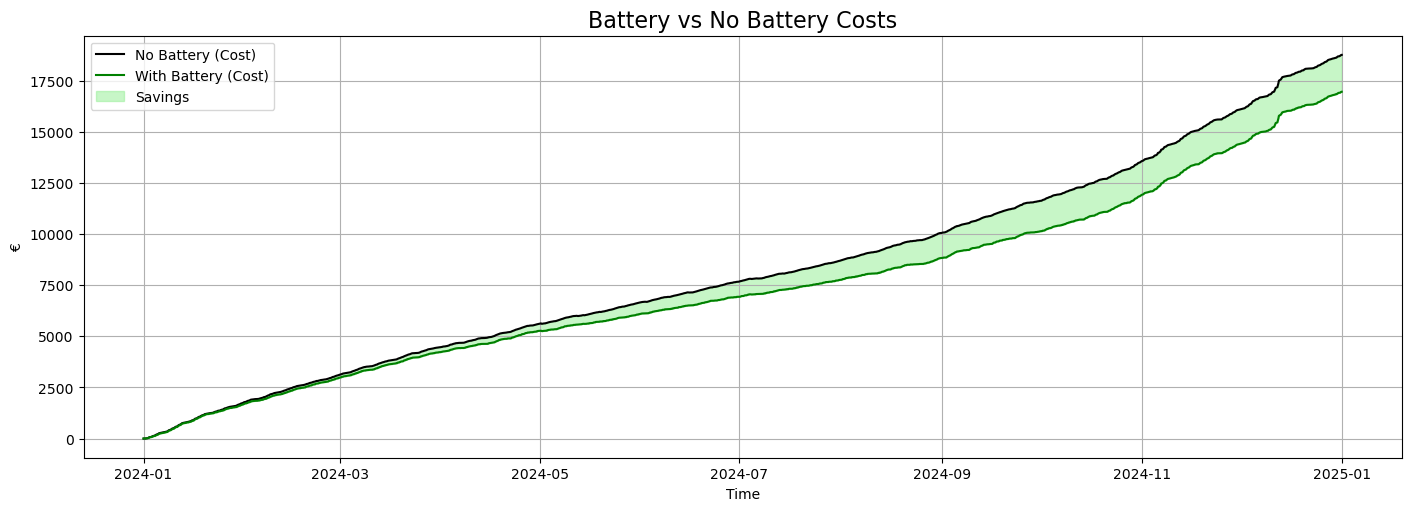

In [12]:
results_baseline = run_baseline_battery(simdata.loc["2024-01-01":"2024-12-31 23:00"])
no_batt_curve, batt_profit_curve, savings = evaluate_strategy(
    df_full=simdata,
    df_battery_result=results_baseline,
    start="2024-01-01",
    end="2024-12-31 23:00"
)

evaluate_battery_result(results_baseline, no_batt_curve, batt_profit_curve)

Estimated total battery cycles in 2024: 781.50
Total import from grid (kWh): 233236.77
Total export to grid (kWh): 5800.95
Total grid interaction (kWh): 239037.72
Peak grid interaction (kWh): 161.35


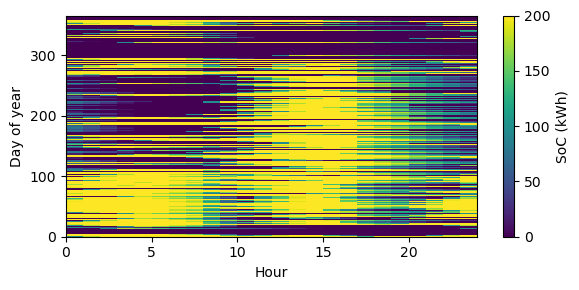

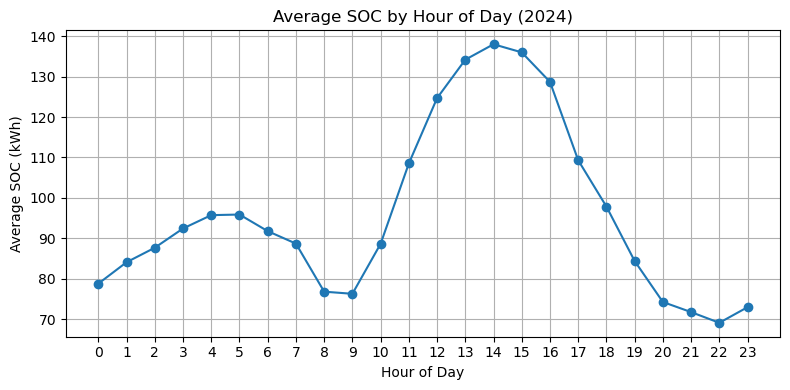

In [22]:
# After running your baseline simulation:
results_baseline = run_baseline_battery(simdata.loc["2024-01-01":"2024-12-31 23:00"])

# Calculate total charge and discharge energy (in kWh)
total_charged = results_baseline["battery_charge_kWh"].sum()
total_discharged = results_baseline["from_batt"].sum()

# Use the average of charge and discharge (or just one, if you prefer)
total_throughput = (total_charged + total_discharged) / 2

# Battery capacity (kWh)
battery_capacity = 200.0

# Estimate total cycles
total_cycles = total_throughput / battery_capacity

print(f"Estimated total battery cycles in 2024: {total_cycles:.2f}")

total_import_from_grid = results_baseline["from_grid"].sum()
total_export_to_grid = results_baseline["energy_sold_kWh"].sum()
total_grid_interaction = total_import_from_grid + total_export_to_grid

print(f"Total import from grid (kWh): {total_import_from_grid:.2f}")
print(f"Total export to grid (kWh): {total_export_to_grid:.2f}")
print(f"Total grid interaction (kWh): {total_grid_interaction:.2f}")

# Calculate peak grid interaction (piekbelasting)
hourly_grid_interaction = results_baseline["from_grid"] + results_baseline["energy_sold_kWh"]
peak_grid_interaction = hourly_grid_interaction.max()

print(f"Peak grid interaction (kWh): {peak_grid_interaction:.2f}")

import numpy as np, pandas as pd, matplotlib.pyplot as plt
soc = results_baseline['soc_kWh']
hm = soc.groupby([soc.index.dayofyear, soc.index.hour]).mean().unstack()
plt.figure(figsize=(6,3))
plt.pcolormesh(hm, cmap='viridis')
plt.ylabel('Day of year'); plt.xlabel('Hour'); plt.colorbar(label='SoC (kWh)')
plt.tight_layout()

# Calculate average SOC for each hour of the day (across the year)
soc_hourly = results_baseline['soc_kWh'].groupby(results_baseline.index.hour).mean()

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot(soc_hourly.index, soc_hourly.values, marker='o')
plt.title('Average SOC by Hour of Day (2024)')
plt.xlabel('Hour of Day')
plt.ylabel('Average SOC (kWh)')
plt.grid(True)
plt.xticks(range(24))
plt.tight_layout()
plt.show()


## 2. MILP for BMS

Is put in other file!

## Load Forecasts to be used by RL methods

In [20]:
# def rolling_AR_predictions(series, horizon=24, days=365, lags=24):
#     last = series.index[-1]
#     first = last - pd.Timedelta(days=days-1)
#     preds = {}
#     dates = list(pd.date_range(first, last, freq='D'))

#     for d in tqdm(dates, desc="Rolling AR Predictions"):
#         y_train = series.loc[:d - pd.Timedelta(hours=1)]
#         if len(y_train) < lags: 
#             continue
#         mdl = AutoReg(y_train, lags=lags, old_names=False).fit()
#         y_hat = mdl.predict(start=len(y_train), end=len(y_train) + horizon - 1)
#         y_hat.index = pd.date_range(d, periods=horizon, freq='h')
#         preds[d] = y_hat

#     # Combine all predictions into a single DataFrame
#     forecasts_df = pd.concat(preds.values(), axis=0)
#     return forecasts_df

# forecasts_df = rolling_AR_predictions(price, horizon=24, days = 1094, lags=24)
# print(f"Start date of forecasts_df: {forecasts_df.index.min()}")
# print(f"End date of forecasts_df: {forecasts_df.index.max()}")

In [23]:
# Import AR forecasts
AR_forecasts_pd = pd.read_csv("../data/AR_predictions_30_6.csv", index_col=0, parse_dates=True)
AR_forecasts = AR_forecasts_pd.squeeze("columns")
AR_forecasts.index = pd.to_datetime(AR_forecasts.index, utc=True).tz_convert("Europe/Amsterdam")

# Import LEAR forecasts
LEAR_forecasts_pd = pd.read_csv("../data/LEAR_predictions_30_6.csv", index_col=0, parse_dates=True)
LEAR_forecasts = LEAR_forecasts_pd.squeeze("columns")
LEAR_forecasts.index = pd.to_datetime(LEAR_forecasts.index, utc=True).tz_convert("Europe/Amsterdam")

# Perfect foresight forecasts
perfect_foresight_forecasts = price.copy()

# Find the latest start date among all series
start_date = max(
    AR_forecasts.index.min(),
    LEAR_forecasts.index.min(),
    perfect_foresight_forecasts.index.min()
)

# Optionally, also align the end date to the earliest end date
end_date = min(
    AR_forecasts.index.max(),
    LEAR_forecasts.index.max(),
    perfect_foresight_forecasts.index.max()
)

# Align all series to this common range
AR_forecasts = AR_forecasts.loc[start_date:end_date]
LEAR_forecasts = LEAR_forecasts.loc[start_date:end_date]
perfect_foresight_forecasts = perfect_foresight_forecasts.loc[start_date:end_date]


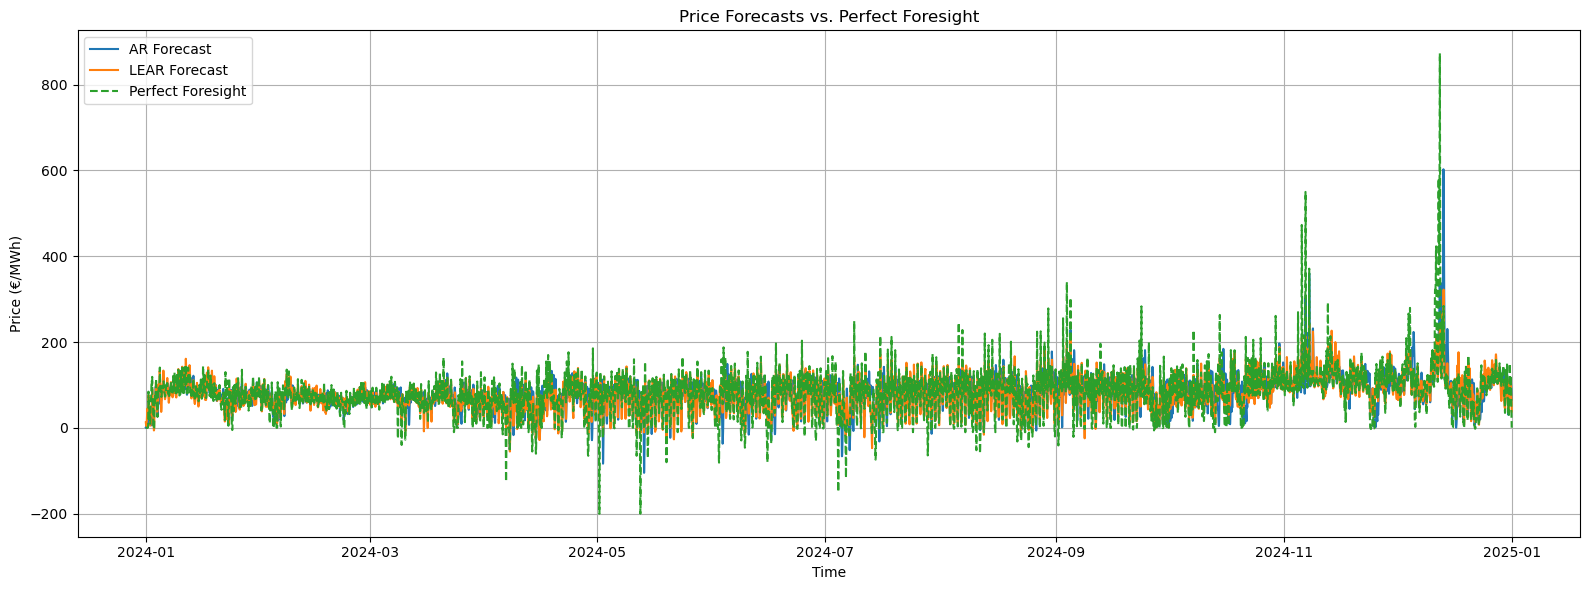

In [24]:
plot_start = "2024-01-01"
plot_end = "2024-12-31 23:00"

plt.figure(figsize=(16, 6))
plt.plot(AR_forecasts.loc[plot_start:plot_end], label="AR Forecast", color="tab:blue")
plt.plot(LEAR_forecasts.loc[plot_start:plot_end], label="LEAR Forecast", color="tab:orange")
plt.plot(perfect_foresight_forecasts.loc[plot_start:plot_end], label="Perfect Foresight", color="tab:green", linestyle="--")
plt.title("Price Forecasts vs. Perfect Foresight")
plt.ylabel("Price (€/MWh)")
plt.xlabel("Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 3. RL methods for BMS

Using object-oriented programming using OpenAI Gymnasium package
Code untill 16-06 was only training on 2024, then testing whole 2023 but real setup should be trained everyday/hour with data from total past

#### Simple discrete 7-actions model (Sage)

In [34]:
import gymnasium as gym
import numpy as np
from stable_baselines3 import DQN
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.callbacks import ProgressBarCallback


SEED = 2025
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)

class BatteryEnv(gym.Env):
    def __init__(self, prices, prices_hat, generation, demand, weather,
                 battery_capacity=200.0, charge_limit=100.0, discharge_limit=100.0, efficiency=0.98, initial_soc=0,
                 discrete_actions=True):
        super(BatteryEnv, self).__init__()
        self.weather = weather
        self.prices = prices / 1000.0  # Convert to €/kWh
        self.prices_hat = prices_hat / 1000.0  # Convert to €/kWh
        self.generation = generation
        self.demand = demand
        self.capacity = battery_capacity
        self.charge_limit = charge_limit
        self.discharge_limit = discharge_limit
        self.efficiency = efficiency
        self.soc = initial_soc
        self.initial_soc = initial_soc  # Store initial SOC for reset
        self.t = 0

        self.discrete = discrete_actions
        
        # Define action and observation spaces
        if self.discrete:
            self.action_space = gym.spaces.Discrete(7)
        else:
            self.action_space = gym.spaces.Box(low=0, high=1, shape=(3,), dtype=np.float32)
        
        self.observation_space = gym.spaces.Box(low=0, high=1, shape=(42,), dtype=np.float32)  # Adjusted for state size
        
        # Tracking metrics
        self.actions = []
        self.soc_list = []

    def reset(self, seed=None, options=None):
        self.t = 0
        self.actions = []
        self.soc = self.initial_soc 
        self.soc_list = []
        return self._get_state(), {}

    def step(self, action):
        price = self.prices.iloc[self.t]
        buy_price = price  # €/kWh
        sell_price = price # €/kWh

        reward = 0
        profit = 0
        initial_soc = self.soc  # Store SOC before the step
        grid_energy_bought = 0  # Energy bought from the grid
        grid_energy_sold = 0  # Energy sold to the grid
        charge_from_battery = 0  # Energy charged into the battery
        discharge_from_battery = 0  # Energy discharged from the battery

        demand = self.demand.iloc[self.t]
        generation = self.generation.iloc[self.t]

        # Fully charge the battery using generated energy
        charge_from_generation = min(generation, self.capacity - self.soc)
        self.soc += charge_from_generation * self.efficiency
        charge_from_battery += charge_from_generation  # Track energy charged into the battery
        generation -= charge_from_generation

        ########## Handle excess generation and demand ##########
        # Route excess generation to meet demand
        pv_to_demand = min(generation, demand)
        demand -= pv_to_demand
        generation -= pv_to_demand

        # Sell remaining excess generation to the grid
        if generation > 0:
            reward += generation * sell_price
            profit += generation * sell_price
            grid_energy_sold += generation  # Track energy sold to the grid
            generation = 0

        ############ Handle actions ##########
        if self.discrete:
            if action == 0:  # Max charge from grid
                charge_amount = min(self.charge_limit, self.capacity - self.soc)
                self.soc += charge_amount * self.efficiency
                reward -= charge_amount * buy_price  # Penalize charging from the grid
                profit -= charge_amount * buy_price  # Penalize charging from the grid
                grid_energy_bought += charge_amount  # Track energy bought from the grid

                unmet_demand = max(0, demand)
                reward -= unmet_demand * buy_price  # Penalize unmet demand
                profit -= unmet_demand * buy_price
                grid_energy_bought += unmet_demand  # Track energy bought to meet unmet demand
                demand = 0  

            elif action == 1:  # Max Half charge
                charge_amount = min(self.charge_limit / 2, self.capacity - self.soc)
                self.soc += charge_amount * self.efficiency
                reward -= charge_amount * buy_price  # Penalize charging from the grid
                profit -= charge_amount * buy_price
                grid_energy_bought += charge_amount  # Track energy bought from the grid

                unmet_demand = max(0, demand)
                reward -= unmet_demand * buy_price  # Penalize unmet demand
                profit -= unmet_demand * buy_price
                grid_energy_bought += unmet_demand  # Track energy bought to meet unmet demand
                demand = 0

            elif action == 2:  # Idle
                unmet_demand = max(0, demand)
                reward -= demand * buy_price
                profit -= demand * buy_price 
                grid_energy_bought += demand  # Track energy bought to meet unmet demand

            elif action == 3:  # Max Half discharge to demand
                discharge_amount = min(self.discharge_limit / 2, self.soc * self.efficiency)
                discharge_to_demand = min(discharge_amount, demand)
                self.soc -= discharge_to_demand / self.efficiency
                discharge_from_battery += discharge_to_demand  # Track energy discharged from the battery

                unmet_demand = max(0, demand - discharge_to_demand)
                reward -= unmet_demand * buy_price  # Penalize grid usage for meeting demand
                profit -= unmet_demand * buy_price
                grid_energy_bought += unmet_demand  # Track energy bought to meet unmet demand
                demand = 0

            elif action == 4:  # Max discharge to demand
                discharge_amount = min(self.discharge_limit, self.soc * self.efficiency)
                discharge_to_demand = min(discharge_amount, demand)
                self.soc -= discharge_to_demand / self.efficiency
                discharge_from_battery += discharge_to_demand  # Track energy discharged from the battery

                unmet_demand = max(0, demand - discharge_to_demand)
                reward -= unmet_demand * buy_price  # Penalize grid usage for meeting demand
                profit -= unmet_demand * buy_price
                grid_energy_bought += unmet_demand  # Track energy bought to meet unmet demand
                demand = 0

            elif action == 5:  # Half discharge to grid
                discharge_amount = min(self.discharge_limit / 2, self.soc * self.efficiency)
                self.soc -= discharge_amount / self.efficiency
                discharge_from_battery += discharge_amount  # Track energy discharged from the battery

                reward += discharge_amount * sell_price  # Reward for selling energy to the grid
                profit += discharge_amount * sell_price
                grid_energy_sold += discharge_amount  # Track energy sold to the grid
                reward -= demand * buy_price  # Penalize unmet demand
                profit -= demand * buy_price
                grid_energy_bought += demand  # Track energy bought to meet unmet demand
                demand = 0

            elif action == 6:  # Full discharge to grid
                discharge_amount = min(self.discharge_limit, self.soc * self.efficiency)
                self.soc -= discharge_amount / self.efficiency
                discharge_from_battery += discharge_amount  # Track energy discharged from the battery

                reward += discharge_amount * sell_price  # Reward for selling energy to the grid
                profit += discharge_amount * sell_price
                grid_energy_sold += discharge_amount  # Track energy sold to the grid
                reward -= demand * buy_price # Penalize unmet demand
                profit -= demand * buy_price
                grid_energy_bought += demand  # Track energy bought to meet unmet demand
                demand = 0
        else:
            # Pick the dominant intention
            if isinstance(action, np.ndarray):
                action = np.squeeze(action)
            if action.shape == ():  # still scalar
                action = np.array([action] * 3)
            a_grid_chg, a_grid_dis, a_dem_dis = action
            winner = int(np.argmax(action))  # 0: charge from grid, 1: discharge to grid, 2: discharge to demand

            # Translate to a power command
            if winner == 0:         # ---------- charge from grid ---------
                p_cmd = +a_grid_chg * self.charge_limit
                target_grid = True
            elif winner == 1:       # ---------- discharge to grid ---------
                p_cmd = -a_grid_dis * self.discharge_limit
                target_grid = True
            else:                   # ---------- discharge to demand -------
                p_cmd = -a_dem_dis * self.discharge_limit
                target_grid = False  # First tries to cover demand

            # Safety clamp
            p_cmd = np.clip(p_cmd, -self.discharge_limit, self.charge_limit)
            # ------------------------------------------------------------------
            # 3) Run the accounting logic using `p_cmd`
            # ------------------------------------------------------------------
            if p_cmd >= 0:  # ======== CHARGE ===================
                real_charge = min(p_cmd, self.capacity - self.soc)
                self.soc += real_charge * self.efficiency
                grid_energy_bought += real_charge
                reward -= real_charge * buy_price
                profit -= real_charge * buy_price

                # Any unmet demand has to be bought from the grid
                unmet_demand = max(0, demand)
                reward -= unmet_demand * buy_price
                profit -= unmet_demand * buy_price
                grid_energy_bought += unmet_demand
                demand = 0

            else:  # ======== DISCHARGE ====================
                discharge = min(-p_cmd, self.soc * self.efficiency)

                if target_grid:  # ---------- sell to grid ----------
                    self.soc -= discharge / self.efficiency
                    reward += discharge * sell_price
                    profit += discharge * sell_price
                    grid_energy_sold += discharge

                    # Grid still needs to cover remaining demand
                    reward -= demand * buy_price
                    profit -= demand * buy_price
                    grid_energy_bought += demand
                    demand = 0
                else:  # ---------- meet demand ----------
                    to_dem = min(discharge, demand)
                    self.soc -= to_dem / self.efficiency
                    discharge_from_battery += to_dem

                    unmet_demand = demand - to_dem
                    reward -= unmet_demand * buy_price
                    profit -= unmet_demand * buy_price
                    grid_energy_bought += unmet_demand
                    demand = 0

        ##### Reward shaping
        # peak_timing_bonus = 1  # Bonus for selling at peak times

        # # Penalize selling too early (according to forecasts)
        # if action in [5, 6]:  # Discharge to grid
        #     future_peak = np.max(self.prices_hat[:6])
        #     if future_peak > price:
        #         penalty = future_peak - price
        #         reward -= discharge_amount * penalty
        # # Penalize charging too early (according to forecasts)
        # if action in [0, 1]:  # Charging from grid
        #     future_min = np.min(self.prices_hat[:6])
        #     if future_min < price:
        #         penalty = price - future_min
        #         reward -= charge_amount * penalty
        # # Encourage peak timing for selling
        # if action in [5, 6]:
        #     peak_t = np.argmax(self.prices_hat[:6])
        #     if peak_t <= 1:
        #         reward += peak_timing_bonus * (6 - peak_t) / 6


        # Ensure SOC is within realistic bounds
        self.soc = max(0, min(self.soc, self.capacity))

        # Calculate the difference in SOC
        delta_soc = self.soc - initial_soc

        self.t += 1
        terminated = self.t >= len(self.prices) - 1
        truncated = False
        self.actions.append(action)
        self.soc_list.append(self.soc)

        # Return state, reward, termination status, and metrics
        return self._get_state(), reward, terminated, truncated, {
            "total_demand": self.demand.iloc[self.t - 1],
            "total_generation": self.generation.iloc[self.t - 1],
            "delta_soc": delta_soc,
            "grid_energy_bought": grid_energy_bought,
            "grid_energy_sold": grid_energy_sold,
            "charge_from_battery": charge_from_battery,
            "discharge_from_battery": discharge_from_battery,
            "profit": profit,
        }

    def _get_state(self):
        price = self.prices.iloc[self.t]
        soc_norm = self.soc / self.capacity
        price_norm = price / self.prices.max()  # Normalize price to its maximum value
        hour = self.t % 24
        sin_hour = np.sin(2 * np.pi * hour / 24)
        cos_hour = np.cos(2 * np.pi * hour / 24)

        demand_norm = self.demand.iloc[self.t] / self.demand.max()  # Normalize demand to its maximum value
        generation_norm = self.generation.iloc[self.t] / self.generation.max()  # Normalize generation to its maximum value
        # Price forecast
        prices_hat = self.prices_hat[self.t:self.t+24] / self.prices_hat.max()  # Normalize price forecast to its maximum value
        if len(prices_hat) < 24:
            prices_hat = np.pad(prices_hat.to_numpy(), (0, 24 - len(prices_hat)), mode='constant')
        else:
            prices_hat = prices_hat.to_numpy().flatten()

        # Price-based features (forecast-aware)
        price_trend = prices_hat[6] - prices_hat[0]
        price_mean_6h = np.mean(prices_hat[:6])
        price_peak_6h = np.max(prices_hat[:6])
        price_peak_later = int(np.argmax(prices_hat) > 6)
        price_above_now = price_peak_6h > price_norm

        # Forecast trend features
        trend_3h = prices_hat[3] - price_norm if len(prices_hat) > 3 else 0
        trend_6h = prices_hat[6] - price_norm if len(prices_hat) > 6 else 0
        trend_mean = np.mean(prices_hat[:6]) - price_norm
        peak_hour = np.argmax(prices_hat) / 24


        # Optional: Add weather forecasts (replace `weather_df` with actual DataFrame passed into env)
        shortwave_norm = self.weather['shortwave_radiation'].iloc[self.t:self.t+6].mean() / self.weather['shortwave_radiation'].max()
        cloudcover_norm = self.weather['cloudcover'].iloc[self.t:self.t+6].mean() / self.weather['cloudcover'].max()
        temperature_norm = self.weather['temperature_2m'].iloc[self.t:self.t+6].mean() / self.weather['temperature_2m'].max()

        state = np.concatenate([
            np.array([
                soc_norm, price_norm, sin_hour, cos_hour, demand_norm, generation_norm, 
                shortwave_norm, cloudcover_norm, temperature_norm,
                trend_3h, trend_6h, trend_mean, peak_hour,
                price_trend, price_mean_6h, price_peak_6h, price_peak_later, price_above_now
            ]),
            prices_hat  # 24 values
        ])


        return state


# Use the aligned start and end dates from your forecasts
aligned_start = AR_forecasts.index.min()  
aligned_end = AR_forecasts.index.max()  

aligned_prices = price.loc[aligned_start:aligned_end]
aligned_generation = simdata["generation_kWh"].loc[aligned_start:aligned_end]
aligned_demand = simdata["demand_kWh"].loc[aligned_start:aligned_end]
aligned_AR = AR_forecasts.loc[aligned_start:aligned_end]
aligned_LEAR = LEAR_forecasts.loc[aligned_start:aligned_end]
aligned_perfect = perfect_foresight_forecasts.loc[aligned_start:aligned_end]

common_index = aligned_prices.index
aligned_generation = aligned_generation.reindex(common_index).interpolate()
aligned_demand = aligned_demand.reindex(common_index).interpolate()
aligned_weather = exog.reindex(common_index).interpolate()

train_end = pd.Timestamp("2023-12-31 23:00:00", tz="Europe/Amsterdam")
test_start = pd.Timestamp("2024-01-01 00:00:00", tz="Europe/Amsterdam")

train_prices = aligned_prices.loc[aligned_start:train_end]
train_generation = aligned_generation.loc[aligned_start:train_end]
train_demand = aligned_demand.loc[aligned_start:train_end]
train_weather = aligned_weather.loc[aligned_start:train_end]
train_AR = aligned_AR.loc[aligned_start:train_end]
train_LEAR = aligned_LEAR.loc[aligned_start:train_end]
train_perfect = aligned_perfect.loc[aligned_start:train_end]

test_prices = aligned_prices.loc[test_start:aligned_end]
test_generation = aligned_generation.loc[test_start:aligned_end]
test_demand = aligned_demand.loc[test_start:aligned_end]
test_weather = aligned_weather.loc[test_start:aligned_end]
test_AR = aligned_AR.loc[test_start:aligned_end]
test_LEAR = aligned_LEAR.loc[test_start:aligned_end]
test_perfect = aligned_perfect.loc[test_start:aligned_end]

# Use LEAR forecasts
train_forecasts = train_perfect  
test_forecasts = test_perfect


In [35]:
# Create training environment

train_env = BatteryEnv(train_prices, train_forecasts, train_generation, train_demand, train_weather,
                       battery_capacity=200.0, charge_limit=100.0, discharge_limit=100.0, efficiency=0.98, initial_soc=0)

# Wrap the environment for compatibility with Stable-Baselines3
vec_train_env = make_vec_env(lambda: train_env, n_envs=1, seed = SEED)

# # Train the model
# print("The model is now Training DQN")
# model = DQN("MlpPolicy", vec_train_env, verbose=0, learning_rate=5e-4, buffer_size=50000, batch_size=64, gamma=0.99, target_update_interval=500, seed = SEED)
# model.learn(total_timesteps = 30000, callback = ProgressBarCallback())

# # Save the trained model  
# model.save("dqn_1-7_Perfect")

# # Load the model (optional)
model = DQN.load("../models/dqn_perfect_1.0")

print("The model is now Testing")
# Create testing environment
test_env = BatteryEnv(test_prices, test_forecasts, test_generation, test_demand, test_weather,
                      battery_capacity=200.0, charge_limit=100.0, discharge_limit=100.0, efficiency=0.98, initial_soc=0)

# Reset the environment
obs, info = test_env.reset(seed = SEED)
done = False
total_reward_rl = 0
total_profit_rl = 0

# Initialize tracking lists
actions_rl, soc_list_rl, profit_list_rl = [], [], []
grid_import_list, grid_export_list = [], []

while not done:
    action, _states = model.predict(obs)
    actions_rl.append(action)
    obs, reward, terminated, truncated, info = test_env.step(action)
    total_reward_rl += reward
    total_profit_rl += info.get("profit", 0)
    soc_list_rl.append(test_env.soc)
    profit_list_rl.append(total_profit_rl)
    grid_import_list.append(info.get("grid_energy_bought", 0))
    grid_export_list.append(info.get("grid_energy_sold", 0))
    done = terminated or truncated

# Create a DataFrame for testing results0
df_rl_result_test = pd.DataFrame({
    "action": actions_rl,
    "soc_kWh": soc_list_rl,
    "cumulative_profit": profit_list_rl,
    "grid_import_kWh": grid_import_list,
    "grid_export_kWh": grid_export_list,
})
df_rl_result_test.index = test_prices.index[:len(df_rl_result_test)]

# Evaluate testing results
print(f"Total reward during testing: {total_reward_rl}")
print(f"Total profit during testing: {total_profit_rl}")

df_rl_result_2024 = df_rl_result_test.loc["2024-01-01 00:00:00":"2024-12-31 23:00:00"]

# Evaluate RL results
no_batt_curve_rl, batt_profit_curve_rl, savings_rl = evaluate_strategy(
    df_full=simdata,
    df_battery_result=df_rl_result_2024,
    start="2024-01-01",
    end="2024-12-31 23:00"
)

The model is now Testing
Total reward during testing: -13919.868314895557
Total profit during testing: -13919.868314895557
💰 No Battery Cost:         €18,768.18
🔋 With Battery Cost:       €13,919.87
✅ Savings from Battery:    €4,848.31
📉 Savings Percentage:       25.83%


In [27]:
# Filter data for 2024
df_rl_result_2024 = df_rl_result_test.loc["2024-01-01 00:00:00":"2024-12-31 23:00:00"].copy()

df_rl_result_test["total_grid_usage_kWh"] = df_rl_result_test["grid_import_kWh"] + df_rl_result_test["grid_export_kWh"]
peak_usage = df_rl_result_test["total_grid_usage_kWh"].max()
total_import = df_rl_result_test["grid_import_kWh"].sum()
total_export = df_rl_result_test["grid_export_kWh"].sum()
print(f"Peak grid usage (kWh): {peak_usage}")
print(f"Total grid import (kWh): {total_import}")
print(f"Total grid export (kWh): {total_export}")

# Visualization
plt.figure(figsize=(20, 10))

# Plot SOC over time
plt.subplot(3, 1, 1)
plt.plot(df_rl_result_2024.index, df_rl_result_2024["soc_kWh"], label="SOC (kWh)", color="blue")
plt.axhline(test_env.capacity, color="red", linestyle="--", label="Battery Capacity")
plt.axhline(0, color="black", linestyle="--", label="Minimum SOC")
plt.title("State of Charge (SOC) Over Time (2024)")
plt.xlabel("Time")
plt.ylabel("SOC (kWh)")
plt.legend()

# Plot cumulative profit over time
plt.subplot(3, 1, 2)
plt.plot(df_rl_result_2024.index, df_rl_result_2024["cumulative_profit"], label="Cumulative Profit (€)", color="green")
plt.title("Cumulative Profit Over Time (2024)")
plt.xlabel("Time")
plt.ylabel("Profit (€)")
plt.legend()

# Plot actions as a histogram
plt.subplot(3, 1, 3)
plt.hist(df_rl_result_2024["action"], bins=np.arange(8) - 0.5, color="purple", rwidth=0.8)
plt.title("Action Distribution (2024)")
plt.xlabel("Action")
plt.ylabel("Frequency")
plt.xticks([0, 1, 2, 3, 4, 5, 6], ["Full Charge", "Half Charge", "Idle", "Half Discharge to Demand", "Full Discharge to Demand", "Half Discharge to Grid", "Full Discharge to Grid"])
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()

# Add a column for the hour of the day
df_rl_result_2024["hour"] = df_rl_result_2024.index.hour

# Group by hour and calculate the average action
average_action_by_hour = df_rl_result_2024.groupby("hour")["action"].mean()

# Plot the average action by hour
plt.figure(figsize=(12, 6))
plt.plot(average_action_by_hour.index, average_action_by_hour.values, marker="o", color="blue", label="Average Action")
plt.title("Average Action Chosen at Each Hour (2024)")
plt.xlabel("Hour of the Day")
plt.ylabel("Average Action")
plt.xticks(range(24))  # Ensure all hours are shown
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend()

# Add labels for actions
plt.yticks([0, 1, 2, 3, 4, 5, 6], ["Full Charge", "Half Charge", "Idle", "Half Discharge to Demand", "Full Discharge to Demand", "Half Discharge to Grid", "Full Discharge to Grid"])

plt.tight_layout()
plt.show()

# Calculate action counts
action_counts = df_rl_result_2024["action"].value_counts().sort_index()

# Define action labels
action_labels = ["Full Charge", "Half Charge", "Idle", "Half Discharge to Demand", "Full Discharge to Demand", "Half Discharge to Grid", "Full Discharge to Grid"]

# Print action counts
print("Action Counts:")
for action, count in action_counts.items():
    print(f"Action: {action_labels[action]} - {count} times")

NameError: name 'df_rl_result_test' is not defined

## PPO - discrete

In [36]:
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.callbacks import ProgressBarCallback

vec_train_env_ppo_d = make_vec_env(
    lambda: BatteryEnv(train_prices, train_forecasts, train_generation,
                       train_demand, train_weather,
                       battery_capacity=200.0, charge_limit=100.0,
                       discharge_limit=100.0, efficiency=0.98,
                       initial_soc=0),
    n_envs=8,           # PPO likes multiple parallel envs
    seed = SEED
)

ppo_params = dict(
    policy               = "MlpPolicy",
    env                  = vec_train_env_ppo_d,
    verbose              = 0,
    learning_rate        = 3e-4,      # Sage 2025 grid-search median
    n_steps              = 24*14,      # rollout horizon
    batch_size           = 2688,
    gamma                = 0.99,
    gae_lambda           = 0.97,
    ent_coef             = 0.005,      # small entropy to keep exploring
    clip_range           = 0.2,
    vf_coef              = 0.5,
    max_grad_norm        = 0.5,
    seed = SEED,
)

# print("Model is now Training with PPO discrete")
# model_ppo = PPO(**ppo_params)
# model_ppo.learn(total_timesteps=3000000, callback=ProgressBarCallback())   # ~3× DQN since PPO is on-policy
# model_ppo.save("ppo_d_1-7_Perfect")  # Save the trained model

# Load the model (optional)
model = PPO.load("../models/ppo_d_perfect_1.0")

print("The model is now Testing")
# Create testing environment
test_env_ppo_d = BatteryEnv(test_prices, test_forecasts, test_generation, test_demand, test_weather,
                      battery_capacity=200.0, charge_limit=100.0, discharge_limit=100.0, efficiency=0.98, initial_soc=0)

# Reset the environment
obs, info = test_env_ppo_d.reset(seed = SEED)
done = False
total_reward_rl_ppo_d = 0
total_profit_rl_ppo_d = 0

# Initialize tracking lists
actions_rl_ppo_d, soc_list_rl_ppo_d, profit_list_rl_ppo_d = [], [], []

while not done:
    action, _states = model.predict(obs)
    actions_rl_ppo_d.append(action)
    obs, reward, terminated, truncated, info = test_env_ppo_d.step(action)
    total_reward_rl_ppo_d += reward
    total_profit_rl_ppo_d += info.get("profit", 0)
    soc_list_rl_ppo_d.append(test_env_ppo_d.soc)
    profit_list_rl_ppo_d.append(total_profit_rl_ppo_d)
    done = terminated or truncated

# Create a DataFrame for testing results0
df_rl_result_test_ppo_d = pd.DataFrame({
    "action": actions_rl_ppo_d,
    "soc_kWh": soc_list_rl_ppo_d,
    "cumulative_profit": profit_list_rl_ppo_d,
})
df_rl_result_test_ppo_d.index = test_prices.index[:len(df_rl_result_test_ppo_d)]

# Evaluate testing results
print(f"Total reward during testing: {total_reward_rl_ppo_d}")
print(f"Total profit during testing: {total_profit_rl_ppo_d}")

df_rl_result_2024_ppo_d = df_rl_result_test_ppo_d.loc["2024-01-01 00:00:00":"2024-12-31 23:00:00"]

# Evaluate RL results
no_batt_curve_rl, batt_profit_curve_rl, savings_rl = evaluate_strategy(
    df_full=simdata,
    df_battery_result=df_rl_result_2024_ppo_d,
    start="2024-01-01",
    end="2024-12-31 23:00"
)

The model is now Testing
Total reward during testing: -12338.669880215983
Total profit during testing: -12338.669880215983
💰 No Battery Cost:         €18,768.18
🔋 With Battery Cost:       €12,338.67
✅ Savings from Battery:    €6,429.51
📉 Savings Percentage:       34.26%


In [29]:
# Filter data for 2024
df_rl_result_2024 = df_rl_result_test_ppo_d.loc["2024-01-01 00:00:00":"2024-12-31 23:00:00"].copy()

# Visualization
plt.figure(figsize=(20, 10))

# Plot SOC over time
plt.subplot(3, 1, 1)
plt.plot(df_rl_result_2024.index, df_rl_result_2024["soc_kWh"], label="SOC (kWh)", color="blue")
plt.axhline(test_env.capacity, color="red", linestyle="--", label="Battery Capacity")
plt.axhline(0, color="black", linestyle="--", label="Minimum SOC")
plt.title("State of Charge (SOC) Over Time (2024)")
plt.xlabel("Time")
plt.ylabel("SOC (kWh)")
plt.legend()

# Plot cumulative profit over time
plt.subplot(3, 1, 2)
plt.plot(df_rl_result_2024.index, df_rl_result_2024["cumulative_profit"], label="Cumulative Profit (€)", color="green")
plt.title("Cumulative Profit Over Time (2024)")
plt.xlabel("Time")
plt.ylabel("Profit (€)")
plt.legend()

# Plot actions as a histogram
plt.subplot(3, 1, 3)
plt.hist(df_rl_result_2024["action"], bins=np.arange(8) - 0.5, color="purple", rwidth=0.8)
plt.title("Action Distribution (2024)")
plt.xlabel("Action")
plt.ylabel("Frequency")
plt.xticks([0, 1, 2, 3, 4, 5, 6], ["Full Charge", "Half Charge", "Idle", "Half Discharge to Demand", "Full Discharge to Demand", "Half Discharge to Grid", "Full Discharge to Grid"])
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()

# Add a column for the hour of the day
df_rl_result_2024["hour"] = df_rl_result_2024.index.hour

# Group by hour and calculate the average action
average_action_by_hour = df_rl_result_2024.groupby("hour")["action"].mean()

# Plot the average action by hour
plt.figure(figsize=(12, 6))
plt.plot(average_action_by_hour.index, average_action_by_hour.values, marker="o", color="blue", label="Average Action")
plt.title("Average Action Chosen at Each Hour (2024)")
plt.xlabel("Hour of the Day")
plt.ylabel("Average Action")
plt.xticks(range(24))  # Ensure all hours are shown
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend()

# Add labels for actions
plt.yticks([0, 1, 2, 3, 4, 5, 6], ["Full Charge", "Half Charge", "Idle", "Half Discharge to Demand", "Full Discharge to Demand", "Half Discharge to Grid", "Full Discharge to Grid"])

plt.tight_layout()
plt.show()

# Calculate action counts
action_counts = df_rl_result_2024["action"].value_counts().sort_index()

# Define action labels
action_labels = ["Full Charge", "Half Charge", "Idle", "Half Discharge to Demand", "Full Discharge to Demand", "Half Discharge to Grid", "Full Discharge to Grid"]

# Print action counts
print("Action Counts:")
for action, count in action_counts.items():
    print(f"Action: {action_labels[action]} - {count} times")

NameError: name 'df_rl_result_test_ppo_d' is not defined

## PPO - Continuous

In [37]:
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env


vec_train_env_ppo_d = make_vec_env(
    lambda: BatteryEnv(train_prices, train_forecasts, train_generation,
                       train_demand, train_weather,
                       battery_capacity=200.0, charge_limit=100.0,
                       discharge_limit=100.0, efficiency=0.98,
                       initial_soc=0, discrete_actions=False),
    n_envs=8,           # PPO likes multiple parallel envs
    seed = SEED
)

ppo_params = dict(
    policy               = "MlpPolicy",
    env                  = vec_train_env_ppo_d,
    verbose              = 0,
    learning_rate        = 3e-4,      # Sage 2025 grid-search median
    n_steps              = 24*14,      # rollout horizon
    batch_size           = 2688,
    gamma                = 0.99,
    gae_lambda           = 0.97,
    ent_coef             = 0.005,      # small entropy to keep exploring
    clip_range           = 0.2,
    vf_coef              = 0.5,
    max_grad_norm        = 0.5,
    seed = SEED,
)

# print("Model is now Training with PPO Continuous")
# model_ppo = PPO(**ppo_params)
# model_ppo.learn(total_timesteps=3000000, callback = ProgressBarCallback())   # ~3× DQN since PPO is on-policy
# model_ppo.save("ppo_c_1-7_Perfect")

# Load the model (optional)
model = PPO.load("../models/ppo_c_perfect_1.0")

print("The model is now Testing")
# Create testing environment
test_env_ppo_d = BatteryEnv(test_prices, test_forecasts, test_generation, test_demand, test_weather,
                      battery_capacity=200.0, charge_limit=100.0, discharge_limit=100.0, efficiency=0.98, initial_soc=0,
                       discrete_actions=False)

# Reset the environment
obs, info = test_env_ppo_d.reset(seed = SEED)
done = False
total_reward_rl_ppo_d = 0
total_profit_rl_ppo_d = 0

# Initialize tracking lists
actions_rl_ppo_d, soc_list_rl_ppo_d, profit_list_rl_ppo_d = [], [], []

while not done:
    action, _states = model.predict(obs)
    actions_rl_ppo_d.append(action)
    obs, reward, terminated, truncated, info = test_env_ppo_d.step(action)
    total_reward_rl_ppo_d += reward
    total_profit_rl_ppo_d += info.get("profit", 0)
    soc_list_rl_ppo_d.append(test_env_ppo_d.soc)
    profit_list_rl_ppo_d.append(total_profit_rl_ppo_d)
    done = terminated or truncated

# Create a DataFrame for testing results0
df_rl_result_test_ppo_d = pd.DataFrame({
    "action": actions_rl_ppo_d,
    "soc_kWh": soc_list_rl_ppo_d,
    "cumulative_profit": profit_list_rl_ppo_d,
})
df_rl_result_test_ppo_d.index = test_prices.index[:len(df_rl_result_test_ppo_d)]

# Evaluate testing results
print(f"Total reward during testing: {total_reward_rl_ppo_d}")
print(f"Total profit during testing: {total_profit_rl_ppo_d}")

df_rl_result_2024_ppo_d = df_rl_result_test_ppo_d.loc["2024-01-01 00:00:00":"2024-12-31 23:00:00"]

# Evaluate RL results
no_batt_curve_rl, batt_profit_curve_rl, savings_rl = evaluate_strategy(
    df_full=simdata,
    df_battery_result=df_rl_result_2024_ppo_d,
    start="2024-01-01",
    end="2024-12-31 23:00"
)

The model is now Testing
Total reward during testing: -13351.082786103672
Total profit during testing: -13351.082786103672
💰 No Battery Cost:         €18,768.18
🔋 With Battery Cost:       €13,351.08
✅ Savings from Battery:    €5,417.10
📉 Savings Percentage:       28.86%


In [32]:
# Filter data for 2024
df_rl_result_2024 = df_rl_result_test_ppo_d.loc["2024-01-01 00:00:00":"2024-12-31 23:00:00"].copy()

# Visualization
plt.figure(figsize=(20, 10))

# Plot SOC over time
plt.subplot(3, 1, 1)
plt.plot(df_rl_result_2024.index, df_rl_result_2024["soc_kWh"], label="SOC (kWh)", color="blue")
plt.axhline(test_env.capacity, color="red", linestyle="--", label="Battery Capacity")
plt.axhline(0, color="black", linestyle="--", label="Minimum SOC")
plt.title("State of Charge (SOC) Over Time (2024)")
plt.xlabel("Time")
plt.ylabel("SOC (kWh)")
plt.legend()

# Plot cumulative profit over time
plt.subplot(3, 1, 2)
plt.plot(df_rl_result_2024.index, df_rl_result_2024["cumulative_profit"], label="Cumulative Profit (€)", color="green")
plt.title("Cumulative Profit Over Time (2024)")
plt.xlabel("Time")
plt.ylabel("Profit (€)")
plt.legend()

# # Plot actions as a histogram
# plt.subplot(3, 1, 3)
# plt.hist(df_rl_result_2024["action"], bins=np.arange(8) - 0.5, color="purple", rwidth=0.8)
# plt.title("Action Distribution (2024)")
# plt.xlabel("Action")
# plt.ylabel("Frequency")
# plt.xticks([0, 1, 2, 3, 4, 5, 6], ["Full Charge", "Half Charge", "Idle", "Half Discharge to Demand", "Full Discharge to Demand", "Half Discharge to Grid", "Full Discharge to Grid"])
# plt.grid(axis="y", linestyle="--", alpha=0.7)

# plt.tight_layout()
# plt.show()

# # Add a column for the hour of the day
# df_rl_result_2024["hour"] = df_rl_result_2024.index.hour

# # Group by hour and calculate the average action
# average_action_by_hour = df_rl_result_2024.groupby("hour")["action"].mean()

# # Plot the average action by hour
# plt.figure(figsize=(12, 6))
# plt.plot(average_action_by_hour.index, average_action_by_hour.values, marker="o", color="blue", label="Average Action")
# plt.title("Average Action Chosen at Each Hour (2024)")
# plt.xlabel("Hour of the Day")
# plt.ylabel("Average Action")
# plt.xticks(range(24))  # Ensure all hours are shown
# plt.grid(axis="y", linestyle="--", alpha=0.7)
# plt.legend()

# # Add labels for actions
# plt.yticks([0, 1, 2, 3, 4, 5, 6], ["Full Charge", "Half Charge", "Idle", "Half Discharge to Demand", "Full Discharge to Demand", "Half Discharge to Grid", "Full Discharge to Grid"])

# plt.tight_layout()
# plt.show()

# # Calculate action counts
# action_counts = df_rl_result_2024["action"].value_counts().sort_index()

# # Define action labels
# action_labels = ["Full Charge", "Half Charge", "Idle", "Half Discharge to Demand", "Full Discharge to Demand", "Half Discharge to Grid", "Full Discharge to Grid"]

# # Print action counts
# print("Action Counts:")
# for action, count in action_counts.items():
#     print(f"Action: {action_labels[action]} - {count} times")

NameError: name 'df_rl_result_test_ppo_d' is not defined

## SAC

In [38]:
from stable_baselines3 import SAC
from stable_baselines3.common.env_util import make_vec_env
# Use LEAR forecasts
train_forecasts = train_AR  
test_forecasts = test_AR

# Create vectorized training environment
vec_train_env_sac = make_vec_env(
    lambda: BatteryEnv(train_prices, train_forecasts, train_generation,
                       train_demand, train_weather,
                       battery_capacity=200.0, charge_limit=100.0,
                       discharge_limit=100.0, efficiency=0.98,
                       initial_soc=0, discrete_actions=False),
    n_envs=1,
    seed = SEED
)

# Define SAC parameters
sac_params = dict(
    policy="MlpPolicy",
    env=vec_train_env_sac,
    verbose=0,
    learning_rate=3e-4,
    buffer_size=100000,
    batch_size=256,
    gamma=0.99,
    tau=0.005,
    ent_coef="auto",
    seed = SEED,
)

# print("Model is now Training with SAC")
# # Train the model
# model_sac = SAC(**sac_params)
# model_sac.learn(total_timesteps=2000000, callback=ProgressBarCallback())
# model_sac.save("sac_battery_cont_1-7")

# Load the model (if already trained)
model_sac = SAC.load("../models/sac_battery_cont_1-7")

# Testing
test_env_sac = BatteryEnv(test_prices, test_forecasts, test_generation, test_demand, test_weather,
                          battery_capacity=200.0, charge_limit=100.0, discharge_limit=100.0, efficiency=0.98,
                          initial_soc=0, discrete_actions=False)

obs, info = test_env_sac.reset(seed = SEED)
done = False
actions_sac, soc_list_sac, profit_list_sac = [], [], []
total_reward_sac, total_profit_sac = 0, 0

while not done:
    action, _states = model_sac.predict(obs)
    actions_sac.append(action)
    obs, reward, terminated, truncated, info = test_env_sac.step(action)
    total_reward_sac += reward
    total_profit_sac += info.get("profit", 0)
    soc_list_sac.append(test_env_sac.soc)
    profit_list_sac.append(total_profit_sac)
    done = terminated or truncated

df_rl_result_test_sac = pd.DataFrame({
    "action": actions_sac,
    "soc_kWh": soc_list_sac,
    "cumulative_profit": profit_list_sac,
})
df_rl_result_test_sac.index = test_prices.index[:len(df_rl_result_test_sac)]

print(f"Total reward during testing: {total_reward_sac}")
print(f"Total profit during testing: {total_profit_sac}")

# Evaluate RL results
no_batt_curve_rl, batt_profit_curve_rl, savings_rl = evaluate_strategy(
    df_full=simdata,
    df_battery_result=df_rl_result_test_sac,
    start="2024-01-01",
    end="2024-12-31 23:00"
)

Total reward during testing: -17760.609636898673
Total profit during testing: -17760.609636898673
💰 No Battery Cost:         €18,768.18
🔋 With Battery Cost:       €17,760.61
✅ Savings from Battery:    €1,007.57
📉 Savings Percentage:       5.37%


## SAC, LEAR

In [ ]:
from stable_baselines3 import SAC
from stable_baselines3.common.env_util import make_vec_env
# Use LEAR forecasts
train_forecasts = train_LEAR  
test_forecasts = test_LEAR

# Create vectorized training environment
vec_train_env_sac = make_vec_env(
    lambda: BatteryEnv(train_prices, train_forecasts, train_generation,
                       train_demand, train_weather,
                       battery_capacity=200.0, charge_limit=100.0,
                       discharge_limit=100.0, efficiency=0.98,
                       initial_soc=0, discrete_actions=False),
    n_envs=1,
    seed = SEED
)

# Define SAC parameters
sac_params = dict(
    policy="MlpPolicy",
    env=vec_train_env_sac,
    verbose=1,
    learning_rate=3e-4,
    buffer_size=100000,
    batch_size=256,
    gamma=0.99,
    tau=0.005,
    ent_coef="auto",
    seed = SEED,
)

print("Model is now Training with SAC")
# Train the model
model_sac = SAC(**sac_params)
model_sac.learn(total_timesteps=2000000, callback=ProgressBarCallback())
model_sac.save("sac_battery_cont_1-7_LEAR")

# Load the model (if already trained)
# model_sac = SAC.load("sac_battery_cont_1")

# Testing
test_env_sac = BatteryEnv(test_prices, test_forecasts, test_generation, test_demand, test_weather,
                          battery_capacity=200.0, charge_limit=100.0, discharge_limit=100.0, efficiency=0.98,
                          initial_soc=0, discrete_actions=False)

obs, info = test_env_sac.reset(seed = SEED)
done = False
actions_sac, soc_list_sac, profit_list_sac = [], [], []
total_reward_sac, total_profit_sac = 0, 0

while not done:
    action, _states = model_sac.predict(obs)
    actions_sac.append(action)
    obs, reward, terminated, truncated, info = test_env_sac.step(action)
    total_reward_sac += reward
    total_profit_sac += info.get("profit", 0)
    soc_list_sac.append(test_env_sac.soc)
    profit_list_sac.append(total_profit_sac)
    done = terminated or truncated

df_rl_result_test_sac = pd.DataFrame({
    "action": actions_sac,
    "soc_kWh": soc_list_sac,
    "cumulative_profit": profit_list_sac,
})
df_rl_result_test_sac.index = test_prices.index[:len(df_rl_result_test_sac)]

print(f"Total reward during testing: {total_reward_sac}")
print(f"Total profit during testing: {total_profit_sac}")

# Evaluate RL results
no_batt_curve_rl, batt_profit_curve_rl, savings_rl = evaluate_strategy(
    df_full=simdata,
    df_battery_result=df_rl_result_test_sac,
    start="2024-01-01",
    end="2024-12-31 23:00"
)

Output()

Model is now Training with SAC
Using cpu device


----------------------------------
| rollout/           |           |
|    ep_len_mean     | 1.62e+04  |
|    ep_rew_mean     | -6.64e+04 |
| time/              |           |
|    episodes        | 4         |
|    fps             | 106       |
|    time_elapsed    | 606       |
|    total_timesteps | 64604     |
| train/             |           |
|    actor_loss      | 517       |
|    critic_loss     | 363       |
|    ent_coef        | 0.188     |
|    ent_coef_loss   | -0.403    |
|    learning_rate   | 0.0003    |
|    n_updates       | 64503     |
----------------------------------


----------------------------------
| rollout/           |           |
|    ep_len_mean     | 1.62e+04  |
|    ep_rew_mean     | -6.65e+04 |
| time/              |           |
|    episodes        | 8         |
|    fps             | 108       |
|    time_elapsed    | 1191      |
|    total_timesteps | 129208    |
| train/             |           |
|    actor_loss      | 643       |
|    critic_loss     | 413       |
|    ent_coef        | 0.207     |
|    ent_coef_loss   | -0.0661   |
|    learning_rate   | 0.0003    |
|    n_updates       | 129107    |
----------------------------------


----------------------------------
| rollout/           |           |
|    ep_len_mean     | 1.62e+04  |
|    ep_rew_mean     | -6.64e+04 |
| time/              |           |
|    episodes        | 12        |
|    fps             | 112       |
|    time_elapsed    | 1724      |
|    total_timesteps | 193812    |
| train/             |           |
|    actor_loss      | 686       |
|    critic_loss     | 270       |
|    ent_coef        | 0.305     |
|    ent_coef_loss   | -0.155    |
|    learning_rate   | 0.0003    |
|    n_updates       | 193711    |
----------------------------------


----------------------------------
| rollout/           |           |
|    ep_len_mean     | 1.62e+04  |
|    ep_rew_mean     | -6.64e+04 |
| time/              |           |
|    episodes        | 16        |
|    fps             | 115       |
|    time_elapsed    | 2230      |
|    total_timesteps | 258416    |
| train/             |           |
|    actor_loss      | 765       |
|    critic_loss     | 307       |
|    ent_coef        | 0.455     |
|    ent_coef_loss   | -0.155    |
|    learning_rate   | 0.0003    |
|    n_updates       | 258315    |
----------------------------------


## SAC, Perfect

In [ ]:
from stable_baselines3 import SAC
from stable_baselines3.common.env_util import make_vec_env
# Use LEAR forecasts
train_forecasts = train_perfect  
test_forecasts = test_perfect

# Create vectorized training environment
vec_train_env_sac = make_vec_env(
    lambda: BatteryEnv(train_prices, train_forecasts, train_generation,
                       train_demand, train_weather,
                       battery_capacity=200.0, charge_limit=100.0,
                       discharge_limit=100.0, efficiency=0.98,
                       initial_soc=0, discrete_actions=False),
    n_envs=1,
    seed = SEED
)

# Define SAC parameters
sac_params = dict(
    policy="MlpPolicy",
    env=vec_train_env_sac,
    verbose=1,
    learning_rate=3e-4,
    buffer_size=100000,
    batch_size=256,
    gamma=0.99,
    tau=0.005,
    ent_coef="auto",
    seed = SEED,
)

print("Model is now Training with SAC")
# Train the model
model_sac = SAC(**sac_params)
model_sac.learn(total_timesteps=2000000, callback=ProgressBarCallback())
model_sac.save("sac_battery_cont_1-7_Perfect")

# Load the model (if already trained)
# model_sac = SAC.load("sac_battery_cont_1")

# Testing
test_env_sac = BatteryEnv(test_prices, test_forecasts, test_generation, test_demand, test_weather,
                          battery_capacity=200.0, charge_limit=100.0, discharge_limit=100.0, efficiency=0.98,
                          initial_soc=0, discrete_actions=False)

obs, info = test_env_sac.reset(seed = SEED)
done = False
actions_sac, soc_list_sac, profit_list_sac = [], [], []
total_reward_sac, total_profit_sac = 0, 0

while not done:
    action, _states = model_sac.predict(obs)
    actions_sac.append(action)
    obs, reward, terminated, truncated, info = test_env_sac.step(action)
    total_reward_sac += reward
    total_profit_sac += info.get("profit", 0)
    soc_list_sac.append(test_env_sac.soc)
    profit_list_sac.append(total_profit_sac)
    done = terminated or truncated

df_rl_result_test_sac = pd.DataFrame({
    "action": actions_sac,
    "soc_kWh": soc_list_sac,
    "cumulative_profit": profit_list_sac,
})
df_rl_result_test_sac.index = test_prices.index[:len(df_rl_result_test_sac)]

print(f"Total reward during testing: {total_reward_sac}")
print(f"Total profit during testing: {total_profit_sac}")

# Evaluate RL results
no_batt_curve_rl, batt_profit_curve_rl, savings_rl = evaluate_strategy(
    df_full=simdata,
    df_battery_result=df_rl_result_test_sac,
    start="2024-01-01",
    end="2024-12-31 23:00"
)

### Parameter Tuning

In [ ]:
# import optuna
# from stable_baselines3.common.evaluation import evaluate_policy
# from stable_baselines3 import DQN
# from stable_baselines3.common.env_util import make_vec_env

# def objective(trial):
#     # Suggest hyperparameters to tune
#     learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-3, log=True)
#     gamma = trial.suggest_float('gamma', 0.90, 0.999)
#     buffer_size = trial.suggest_categorical('buffer_size', [10000, 50000])
#     batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
#     target_update_interval = trial.suggest_int('target_update_interval', 100, 1000)

#     # Create a fresh training environment for each trial
#     train_env_trial = make_vec_env(lambda: BatteryEnv(
#         train_prices, train_forecasts, train_generation, train_demand, train_weather,
#         battery_capacity=200.0, charge_limit=100.0, discharge_limit=100.0, efficiency=0.98, initial_soc=0
#     ), n_envs=1)

#     # Create a separate test environment
#     test_env_trial = make_vec_env(lambda: BatteryEnv(
#         test_prices, test_forecasts, test_generation, test_demand, test_weather,
#         battery_capacity=200.0, charge_limit=100.0, discharge_limit=100.0, efficiency=0.98, initial_soc=0
#     ), n_envs=1)

#     # Initialize the RL model with hyperparameters
#     model = DQN(
#         "MlpPolicy", train_env_trial, verbose=0,
#         learning_rate=learning_rate,
#         gamma=gamma,
#         buffer_size=buffer_size,
#         batch_size=batch_size,
#         target_update_interval=target_update_interval,
#         train_freq=1
#     )

#     # Train the model
#     model.learn(total_timesteps=50000)  # Increase timesteps for better convergence

#     total_profit = 0
#     for _ in range(10):  # Evaluate on 10 episodes
#         obs, _ = test_env_trial.reset()
#         done = False
#         while not done:
#             action, _ = model.predict(obs)
#             obs, reward, terminated, truncated, info = test_env_trial.envs[0].step(action)
#             total_profit += info.get("profit", 0)
#             done = terminated or truncated

#     return total_profit  # Return the total profit as the objective to maximize

# # Create and optimize the study
# study = optuna.create_study(direction="maximize", storage="sqlite:///optuna_study.db", load_if_exists=True)
# study.optimize(objective, n_trials=50, n_jobs=1)  # Use parallel optimization with 4 workers

# # Print the best hyperparameters
# print("Best trial:")
# print(study.best_trial)

# # Save the best model
# best_params = study.best_params
# print("Best hyperparameters:", best_params)